In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate_south.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   lucca
   2   viterbo
   3   brindisi
   4   rieti
   5   arezzo
   6   massa
   7   siena
   8   sassari
   9   carbonia
   10   ancona
   11   caltanissetta
   12   savona
   13   pisa
   14   taranto
   15   livorno
   16   chieti
   17   siracusa
   18   cosenza
   19   matera
   20   foggia
   21   imperia
   22   prato
   23   firenze
   24   roma
   25   genova
   26   frosinone
   27   trapani
   28   enna
   29   cagliari
   30   agrigento
   31   l_aquila
   32   crotone
   33   latina
   34   lecce
   35   benevento
   36   bat
   37   ragusa
   38   ascoli_piceno
   39   campobasso
   40   potenza
   41   catania
   42   avellino
   43   isernia
   44   reggio_di_calabria
   45   catanzaro
   46   fermo
   47   pistoia
   48   bari
   49   macerata
   50   la_spezia
   51   palermo
   52   messina
   53   nuoro
   54   terni
   55   caserta
   56   salerno
   57   pesaro
   58   grosseto
   59  

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 lucca
2 viterbo
3 brindisi
4 rieti
5 arezzo
6 massa
7 siena
8 sassari
9 ancona
10 caltanissetta
11 savona
12 pisa
13 taranto
14 livorno
15 chieti
16 siracusa
17 cosenza
18 matera
19 foggia
20 imperia
21 prato
22 firenze
23 roma
24 genova
25 frosinone
26 trapani
27 enna
28 cagliari
29 agrigento
30 l_aquila
31 crotone
32 latina
33 lecce
34 benevento
35 bat
36 ragusa
37 ascoli_piceno
38 campobasso
39 potenza
40 catania
41 avellino
42 reggio_di_calabria
43 catanzaro
44 fermo
45 pistoia
46 bari
47 macerata
48 la_spezia
49 palermo
50 messina
51 nuoro
52 terni
53 caserta
54 salerno
55 pesaro
56 grosseto
57 teramo
58 napoli
59 pescara
60 vibo_valentia
61 oristano
62 perugia


In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wno_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
population
    avg_wno_period1_2020
avg_wco_period1_2020
    avg_wnmvo

In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

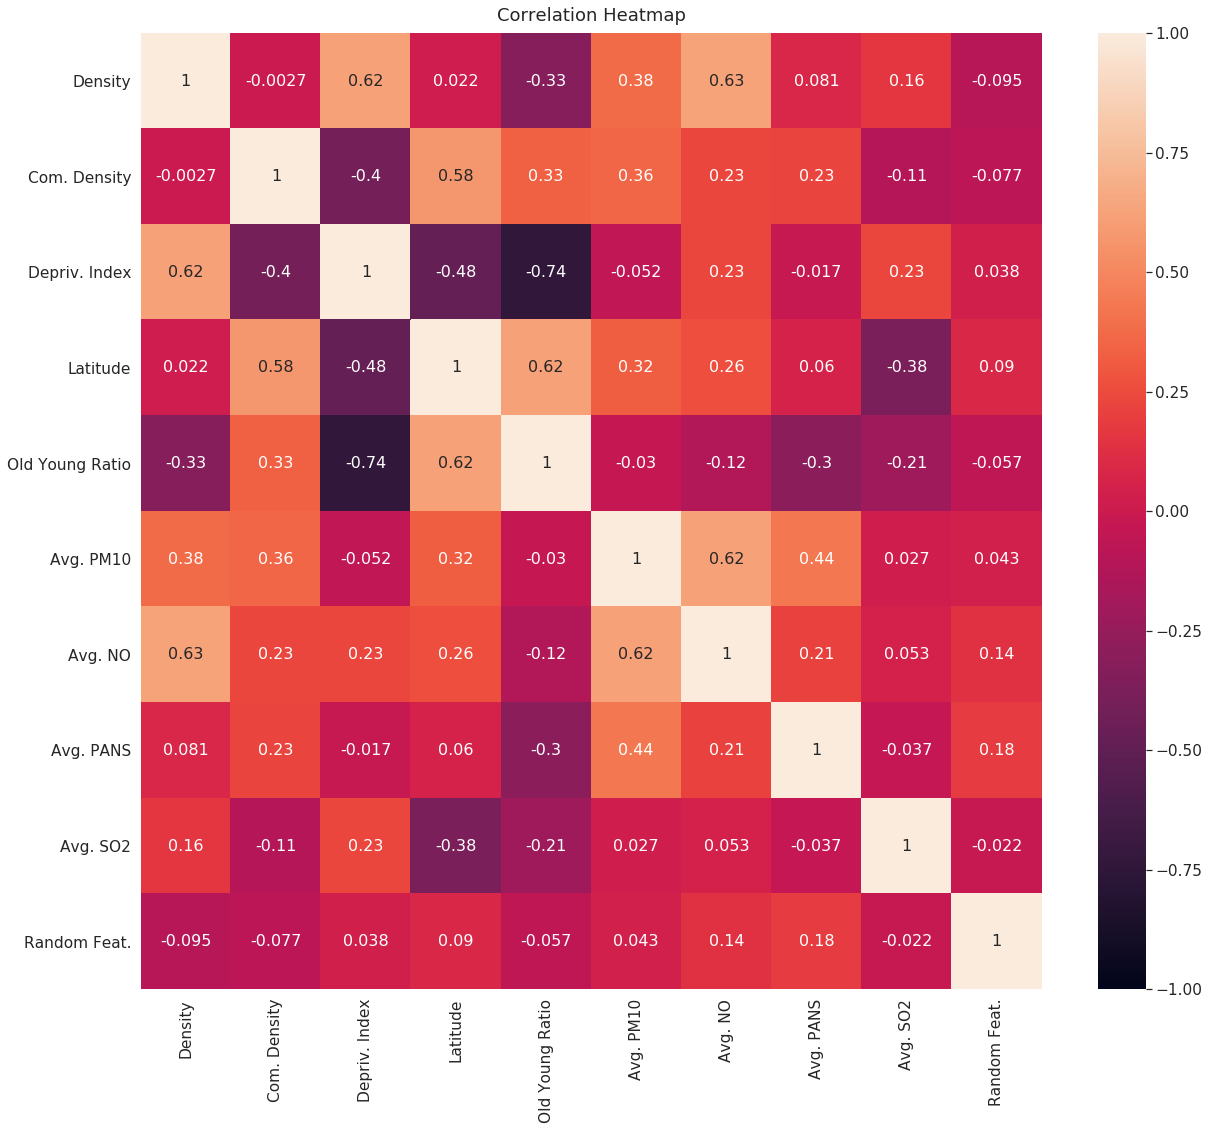

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.32277  0.04200 
    Test set average RMSE:  0.88040  0.10011 

Prediction STD :    0.94511
True value STD :    1.15017
Difference in percentage:   17.82908

             Fullset RMSE:    0.31290
                       R2:    0.92599


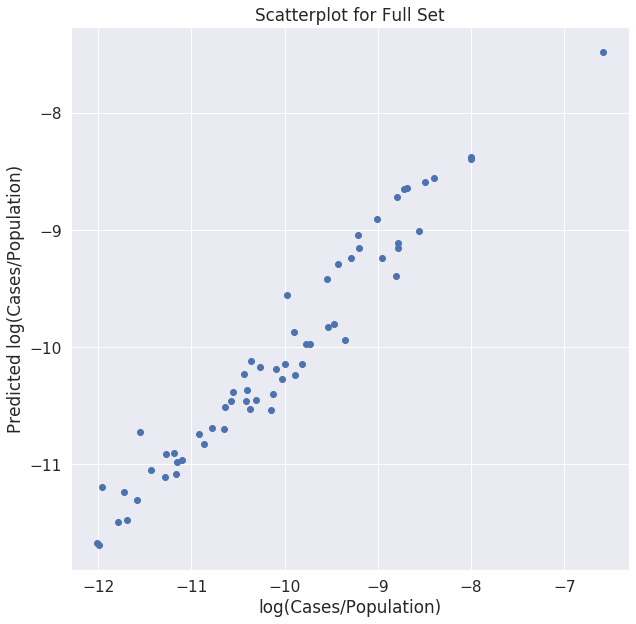

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.16335 +/- 0.03048
Feature:                  Depriv. Index, Score: 0.09767 +/- 0.01582
Feature:                       Latitude, Score: 0.48614 +/- 0.06897
Feature:                Old Young Ratio, Score: 0.08847 +/- 0.00935
Feature:                        Avg. NO, Score: 0.10868 +/- 0.01556


<Figure size 432x288 with 0 Axes>

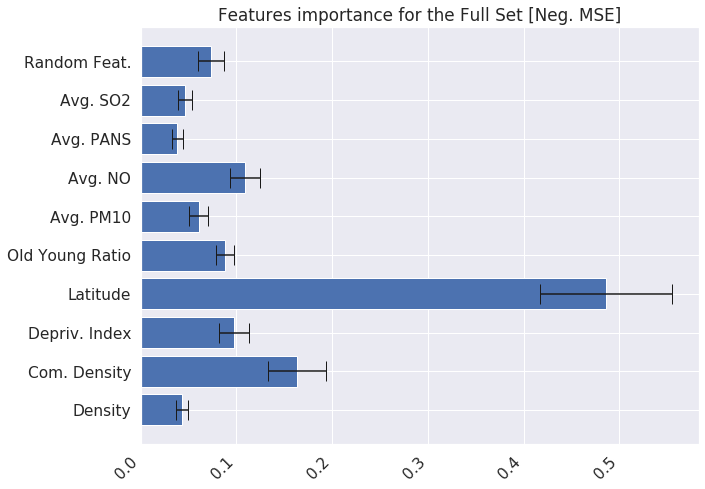

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.12348 +/- 0.02304
Feature:                  Depriv. Index, Score: 0.07383 +/- 0.01196
Feature:                       Latitude, Score: 0.36748 +/- 0.05213
Feature:                Old Young Ratio, Score: 0.06688 +/- 0.00707
Feature:                        Avg. NO, Score: 0.08215 +/- 0.01176


<Figure size 432x288 with 0 Axes>

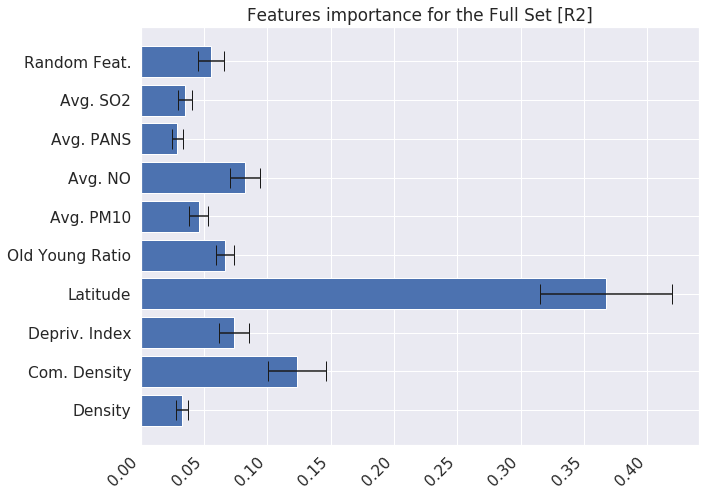

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.37115
                       R2:    0.90818


<Figure size 432x288 with 0 Axes>

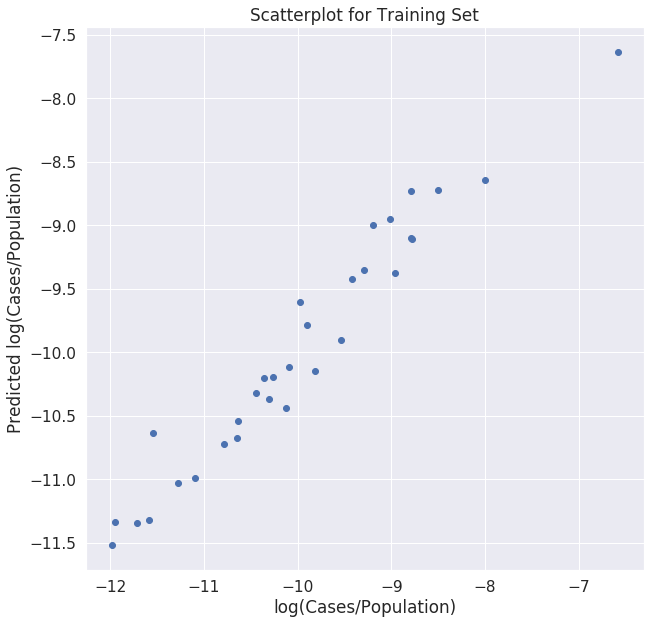

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.75821
                       R2:    0.49301


<Figure size 432x288 with 0 Axes>

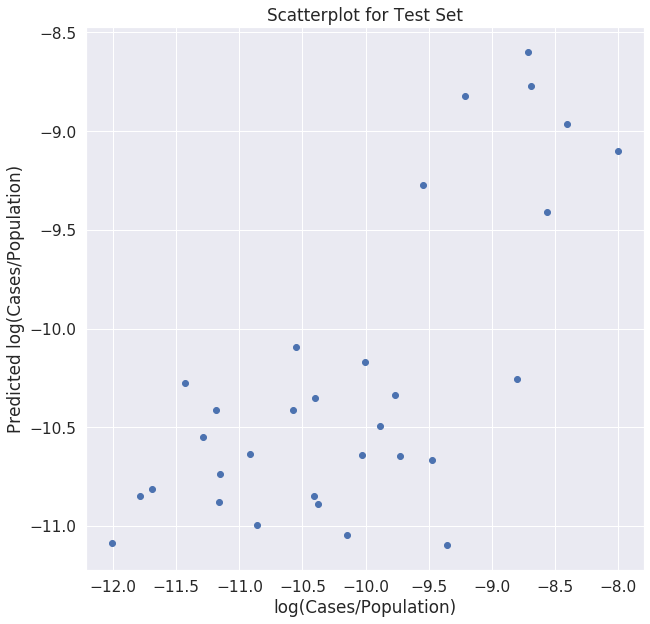

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.07395 +/- 0.04212
Feature:                  Depriv. Index, Score: 0.01380 +/- 0.01944
Feature:                       Latitude, Score: 0.41698 +/- 0.13102
Feature:                Old Young Ratio, Score: 0.00221 +/- 0.01333
Feature:                        Avg. NO, Score: 0.04863 +/- 0.04735


<Figure size 432x288 with 0 Axes>

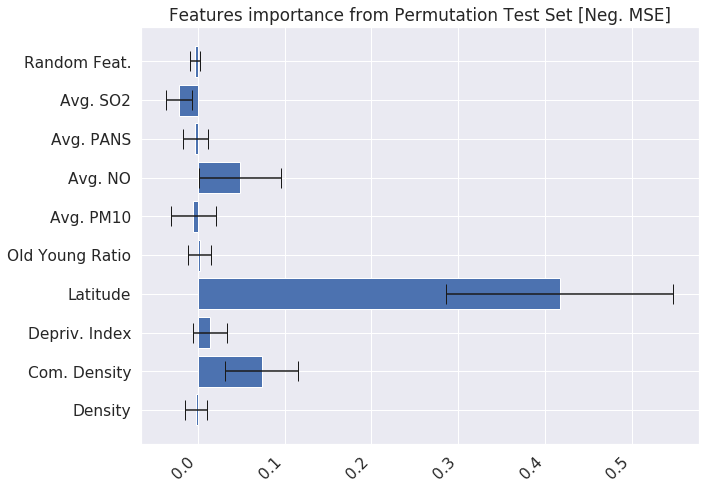

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.06522 +/- 0.03714
Feature:                  Depriv. Index, Score: 0.01217 +/- 0.01714
Feature:                       Latitude, Score: 0.36774 +/- 0.11554
Feature:                Old Young Ratio, Score: 0.00195 +/- 0.01175
Feature:                        Avg. NO, Score: 0.04289 +/- 0.04175


<Figure size 432x288 with 0 Axes>

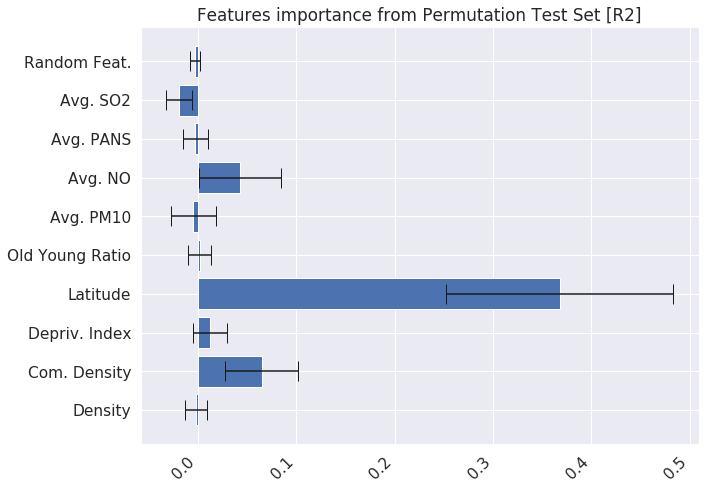

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.04202 +/- 0.00686
Feature:                   Com. Density, Score: 0.14723 +/- 0.03553
Feature:                  Depriv. Index, Score: 0.10994 +/- 0.02221
Feature:                       Latitude, Score: 0.54569 +/- 0.10752
Feature:                Old Young Ratio, Score: 0.05267 +/- 0.00916
Feature:                      Avg. PM10, Score: 0.09284 +/- 0.02446
Feature:                        Avg. NO, Score: 0.14213 +/- 0.03465
Feature:                      Avg. PANS, Score: 0.04816 +/- 0.00928
Feature:                       Avg. SO2, Score: 0.05957 +/- 0.01693


<Figure size 432x288 with 0 Axes>

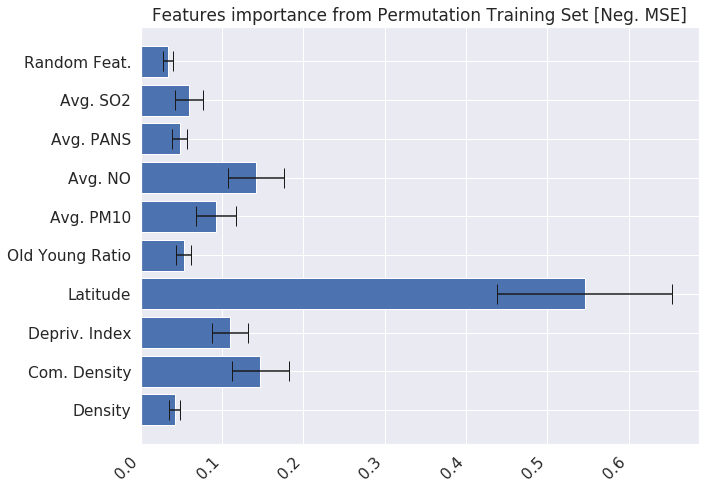

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.02800 +/- 0.00457
Feature:                   Com. Density, Score: 0.09813 +/- 0.02368
Feature:                  Depriv. Index, Score: 0.07328 +/- 0.01480
Feature:                       Latitude, Score: 0.36371 +/- 0.07166
Feature:                Old Young Ratio, Score: 0.03511 +/- 0.00611
Feature:                      Avg. PM10, Score: 0.06188 +/- 0.01630
Feature:                        Avg. NO, Score: 0.09473 +/- 0.02310
Feature:                      Avg. PANS, Score: 0.03210 +/- 0.00618
Feature:                       Avg. SO2, Score: 0.03970 +/- 0.01129


<Figure size 432x288 with 0 Axes>

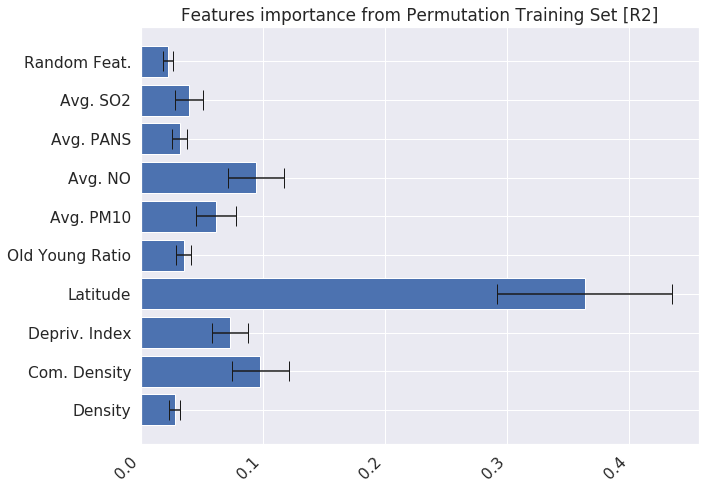

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.35463  0.03977 
    Test set average RMSE:  0.93997  0.11513 

Prediction STD :    0.90271
True value STD :    1.15017
Difference in percentage:   21.51473

             Fullset RMSE:    0.34527
                       R2:    0.90989


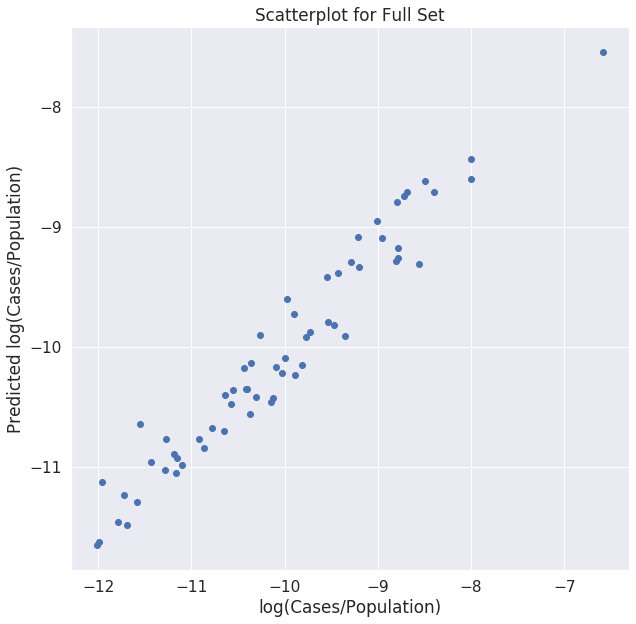

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.33012 +/- 0.05932
Feature:                  Depriv. Index, Score: 0.20853 +/- 0.03677
Feature:                Old Young Ratio, Score: 0.16295 +/- 0.02001
Feature:                      Avg. PM10, Score: 0.10540 +/- 0.01892
Feature:                        Avg. NO, Score: 0.19340 +/- 0.02982
Feature:                       Avg. SO2, Score: 0.08000 +/- 0.01554


<Figure size 432x288 with 0 Axes>

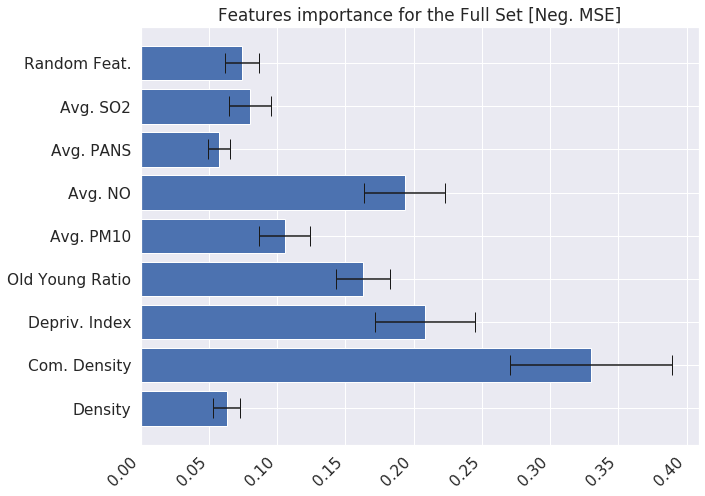

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.24954 +/- 0.04484
Feature:                  Depriv. Index, Score: 0.15763 +/- 0.02779
Feature:                Old Young Ratio, Score: 0.12317 +/- 0.01512
Feature:                      Avg. PM10, Score: 0.07968 +/- 0.01430
Feature:                        Avg. NO, Score: 0.14620 +/- 0.02254
Feature:                       Avg. SO2, Score: 0.06047 +/- 0.01175


<Figure size 432x288 with 0 Axes>

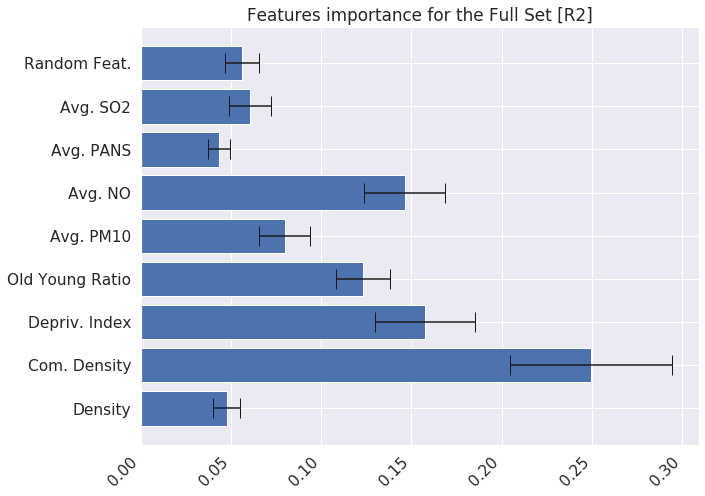

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.41640
                       R2:    0.89047


<Figure size 432x288 with 0 Axes>

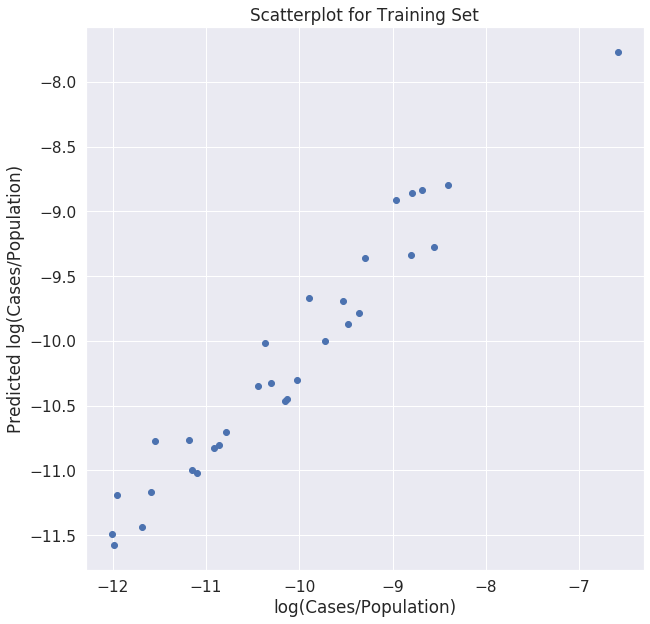

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.75144
                       R2:    0.46210


<Figure size 432x288 with 0 Axes>

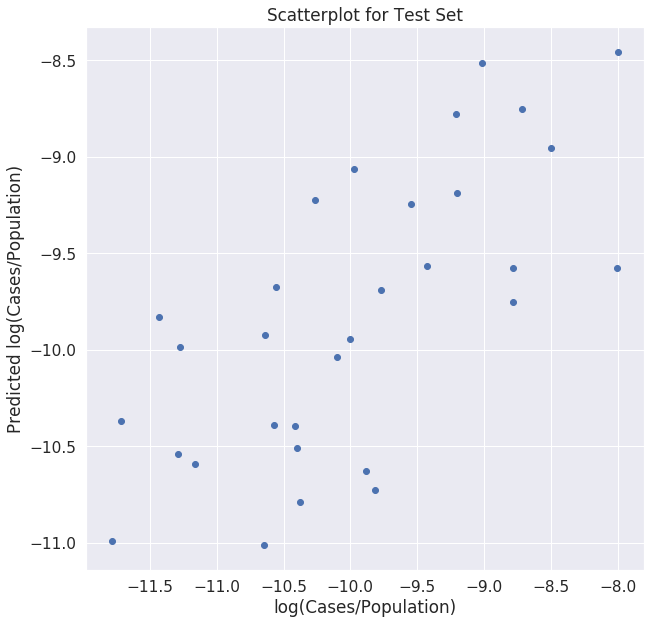

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.22737 +/- 0.09012
Feature:                  Depriv. Index, Score: 0.07161 +/- 0.04439
Feature:                Old Young Ratio, Score: 0.06366 +/- 0.04028
Feature:                        Avg. NO, Score: 0.14190 +/- 0.08181


<Figure size 432x288 with 0 Axes>

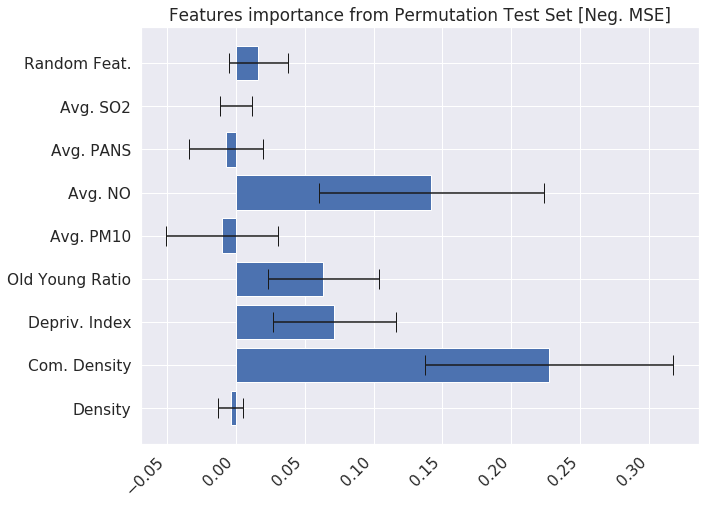

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.21660 +/- 0.08585
Feature:                  Depriv. Index, Score: 0.06821 +/- 0.04229
Feature:                Old Young Ratio, Score: 0.06065 +/- 0.03837
Feature:                        Avg. NO, Score: 0.13518 +/- 0.07793


<Figure size 432x288 with 0 Axes>

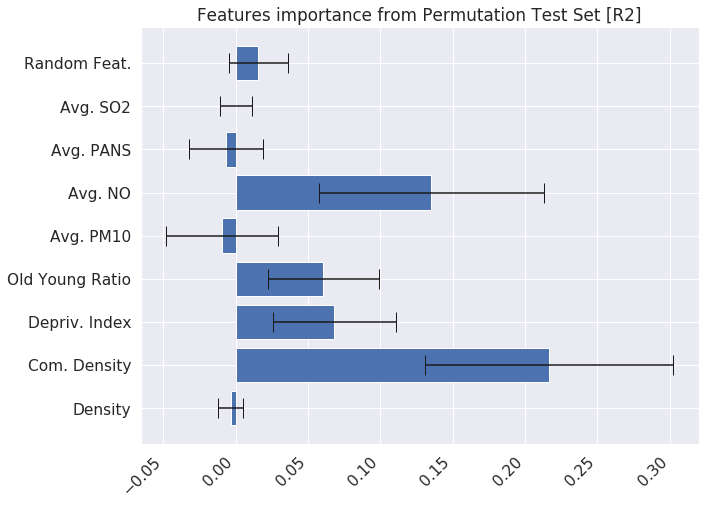

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.20154 +/- 0.03370
Feature:                  Depriv. Index, Score: 0.14647 +/- 0.02545
Feature:                Old Young Ratio, Score: 0.21555 +/- 0.04195
Feature:                      Avg. PM10, Score: 0.12436 +/- 0.02627
Feature:                        Avg. NO, Score: 0.39665 +/- 0.09967


<Figure size 432x288 with 0 Axes>

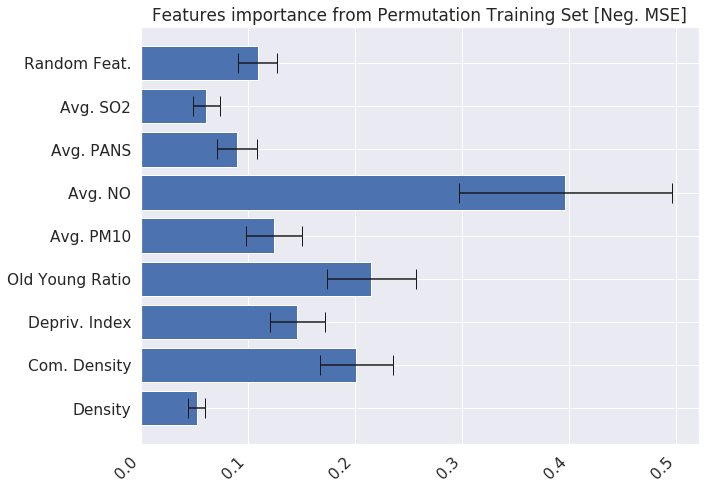

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.12731 +/- 0.02129
Feature:                  Depriv. Index, Score: 0.09252 +/- 0.01608
Feature:                Old Young Ratio, Score: 0.13616 +/- 0.02650
Feature:                      Avg. PM10, Score: 0.07856 +/- 0.01659
Feature:                        Avg. NO, Score: 0.25056 +/- 0.06296


<Figure size 432x288 with 0 Axes>

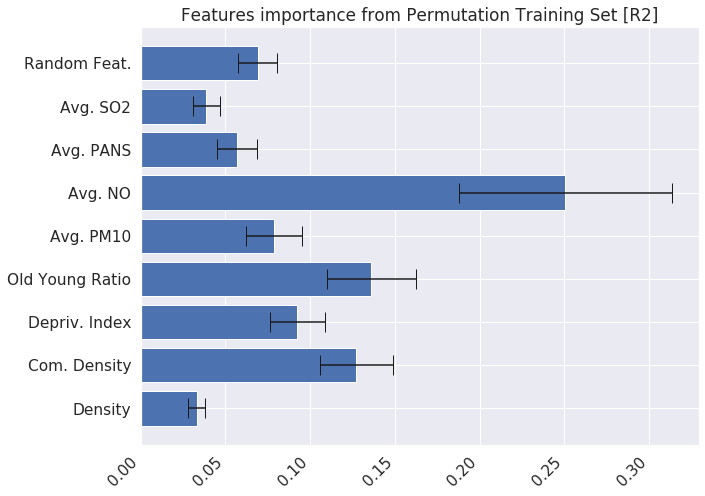

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36024  0.04303 
    Test set average RMSE:  1.01477  0.12401 

Prediction STD :    0.87777
True value STD :    1.15017
Difference in percentage:   23.68361

             Fullset RMSE:    0.35225
                       R2:    0.90620


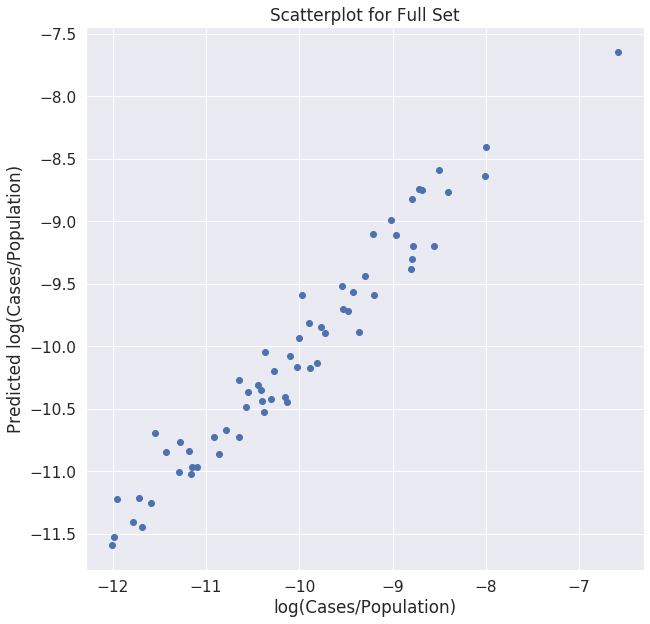

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.10085 +/- 0.01342
Feature:                  Depriv. Index, Score: 0.31610 +/- 0.05842
Feature:                Old Young Ratio, Score: 0.25957 +/- 0.03104
Feature:                      Avg. PM10, Score: 0.15426 +/- 0.02791
Feature:                        Avg. NO, Score: 0.25454 +/- 0.03772
Feature:                       Avg. SO2, Score: 0.10035 +/- 0.01610


<Figure size 432x288 with 0 Axes>

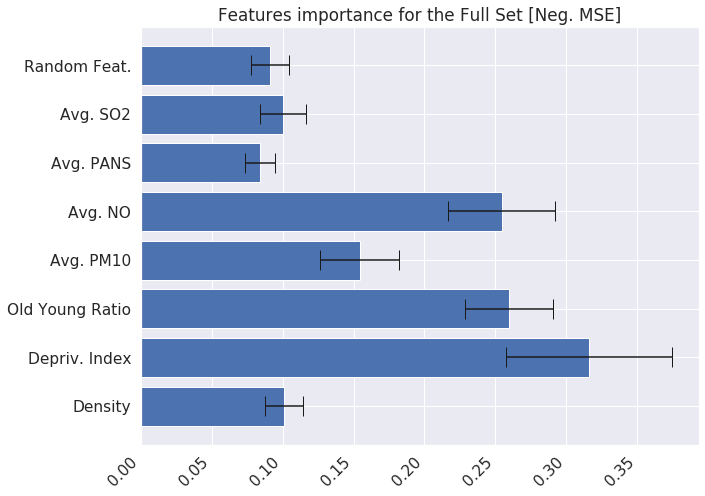

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.07623 +/- 0.01015
Feature:                  Depriv. Index, Score: 0.23895 +/- 0.04416
Feature:                Old Young Ratio, Score: 0.19622 +/- 0.02346
Feature:                      Avg. PM10, Score: 0.11661 +/- 0.02109
Feature:                        Avg. NO, Score: 0.19242 +/- 0.02852
Feature:                       Avg. SO2, Score: 0.07585 +/- 0.01217


<Figure size 432x288 with 0 Axes>

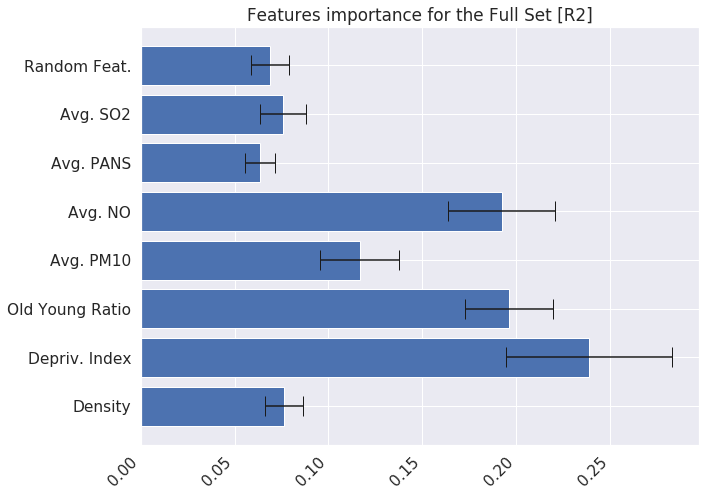

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.40007
                       R2:    0.89449


<Figure size 432x288 with 0 Axes>

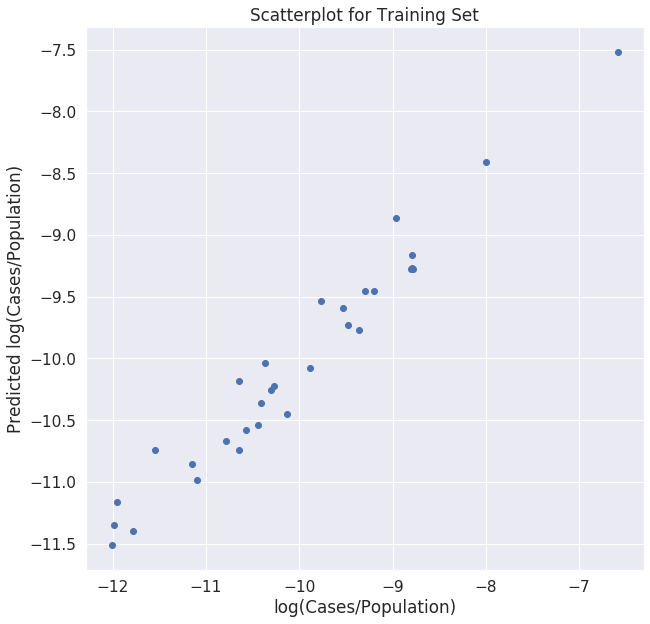

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.99354
                       R2:    0.12516


<Figure size 432x288 with 0 Axes>

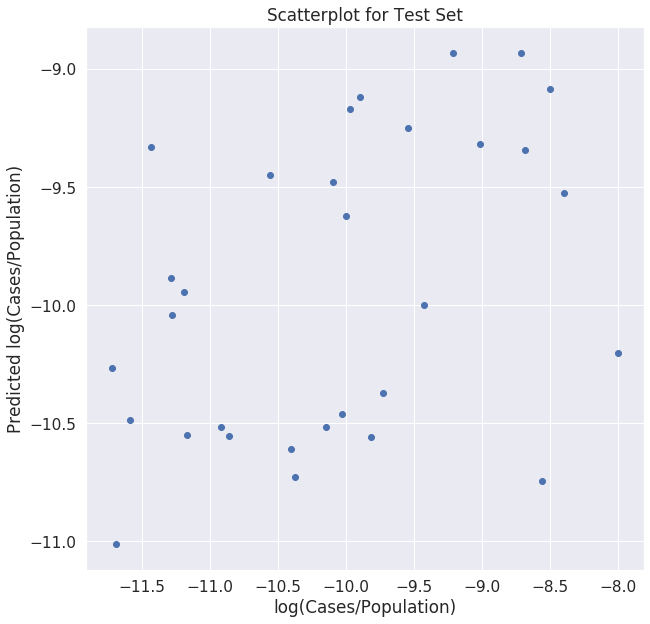

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.12135 +/- 0.06593
Feature:                Old Young Ratio, Score: 0.08649 +/- 0.03848
Feature:                        Avg. NO, Score: 0.06046 +/- 0.09579
Feature:                       Avg. SO2, Score: 0.01193 +/- 0.02001


<Figure size 432x288 with 0 Axes>

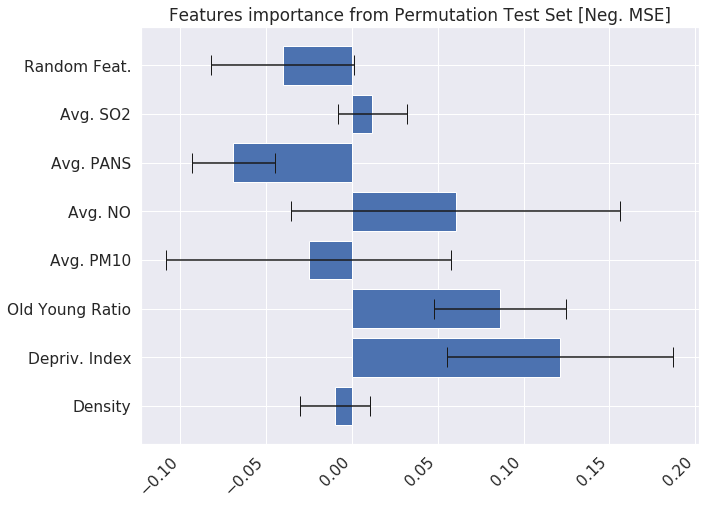

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.10755 +/- 0.05843
Feature:                Old Young Ratio, Score: 0.07666 +/- 0.03410
Feature:                        Avg. NO, Score: 0.05358 +/- 0.08489
Feature:                       Avg. SO2, Score: 0.01058 +/- 0.01773


<Figure size 432x288 with 0 Axes>

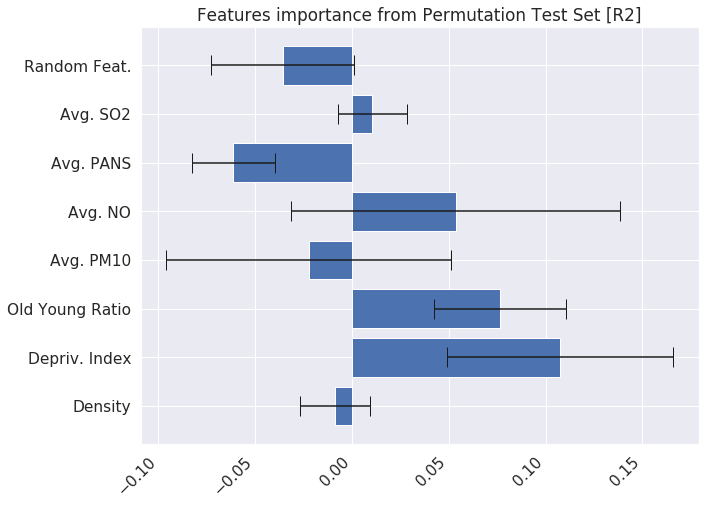

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.24783 +/- 0.05698
Feature:                      Avg. PM10, Score: 0.25780 +/- 0.06785
Feature:                        Avg. NO, Score: 0.27516 +/- 0.07262


<Figure size 432x288 with 0 Axes>

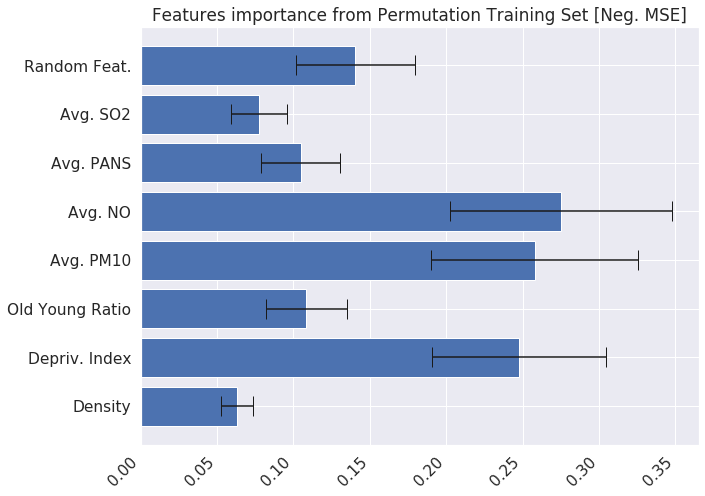

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                  Depriv. Index, Score: 0.16336 +/- 0.03756
Feature:                      Avg. PM10, Score: 0.16993 +/- 0.04473
Feature:                        Avg. NO, Score: 0.18138 +/- 0.04787


<Figure size 432x288 with 0 Axes>

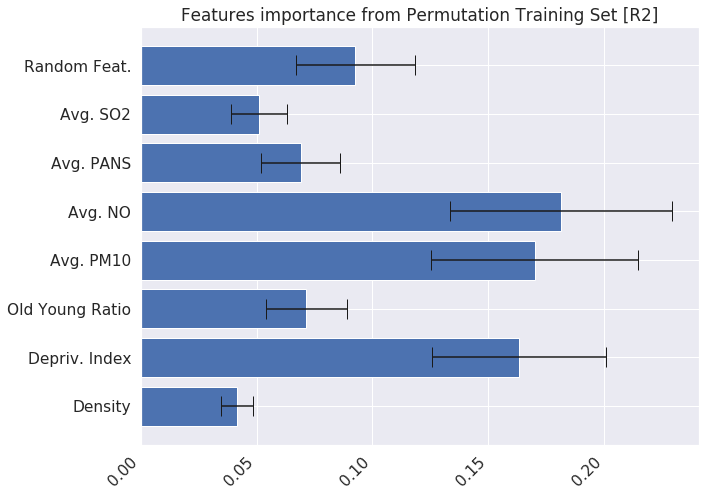

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Training Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.32077  0.04360 
    Test set average RMSE:  0.88362  0.09370 

Prediction STD :    0.98915
True value STD :    1.15017
Difference in percentage:   14.00001

             Fullset RMSE:    0.33103
                       R2:    0.91717


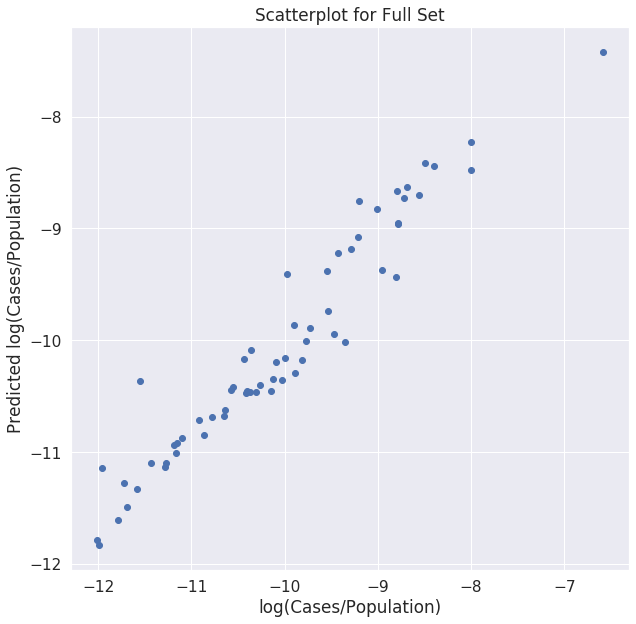

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                       Latitude, Score: 1.65138 +/- 0.24650


<Figure size 432x288 with 0 Axes>

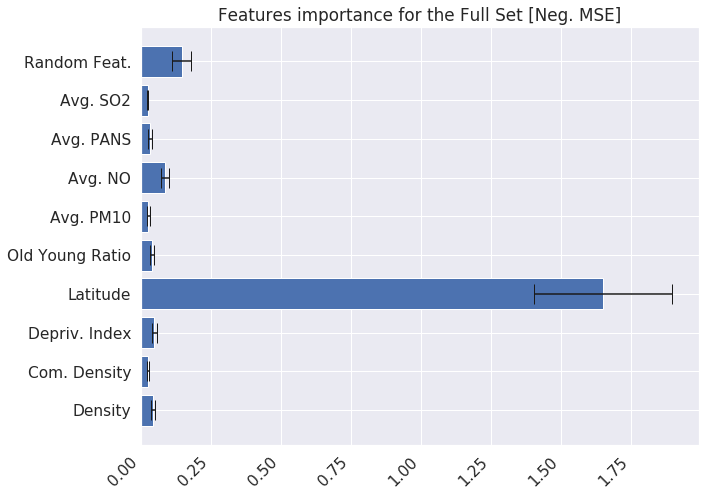

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                       Latitude, Score: 1.24831 +/- 0.18633


<Figure size 432x288 with 0 Axes>

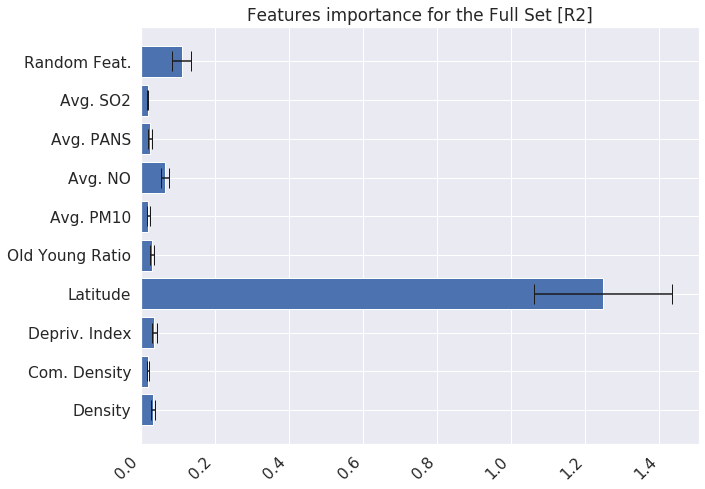

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.35149
                       R2:    0.91866


<Figure size 432x288 with 0 Axes>

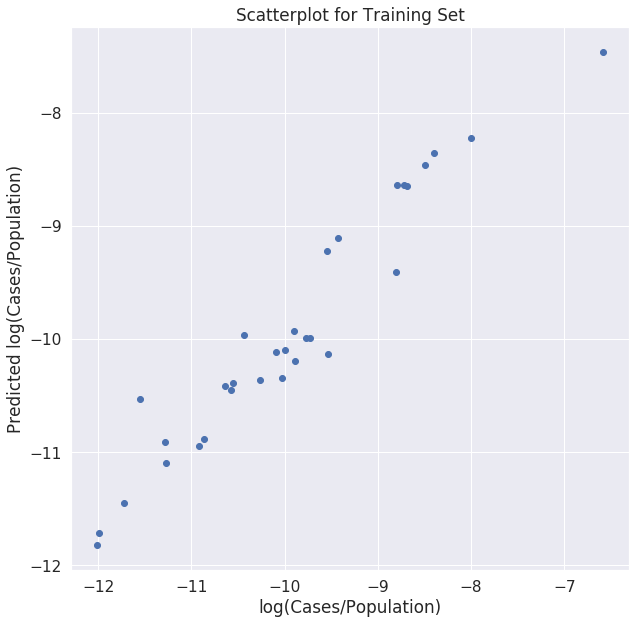

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.84274
                       R2:    0.35703


<Figure size 432x288 with 0 Axes>

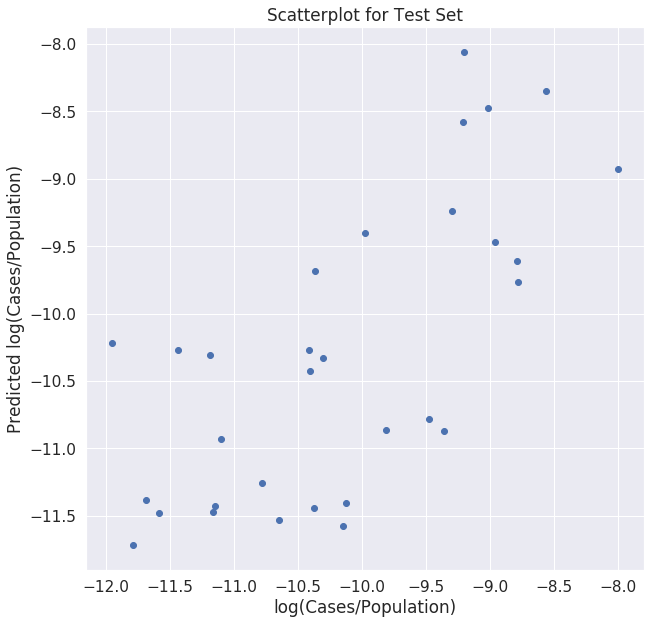

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.01571 +/- 0.02276
Feature:                       Latitude, Score: 0.94072 +/- 0.33225
Feature:                       Avg. SO2, Score: 0.02607 +/- 0.02001


<Figure size 432x288 with 0 Axes>

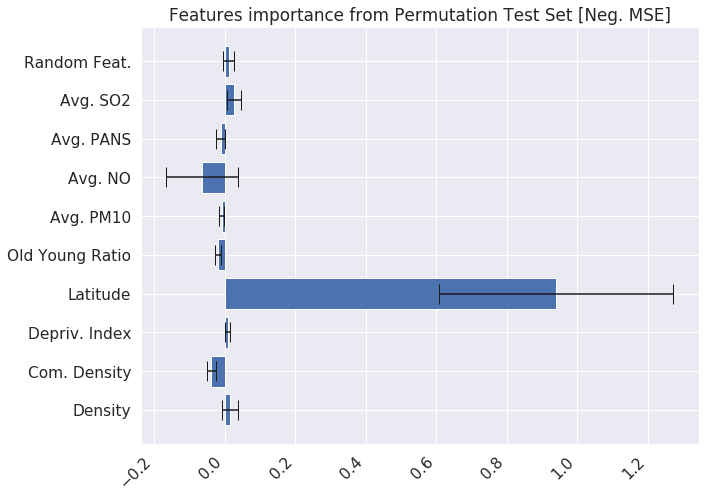

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.01422 +/- 0.02060
Feature:                       Latitude, Score: 0.85166 +/- 0.30080
Feature:                       Avg. SO2, Score: 0.02361 +/- 0.01812


<Figure size 432x288 with 0 Axes>

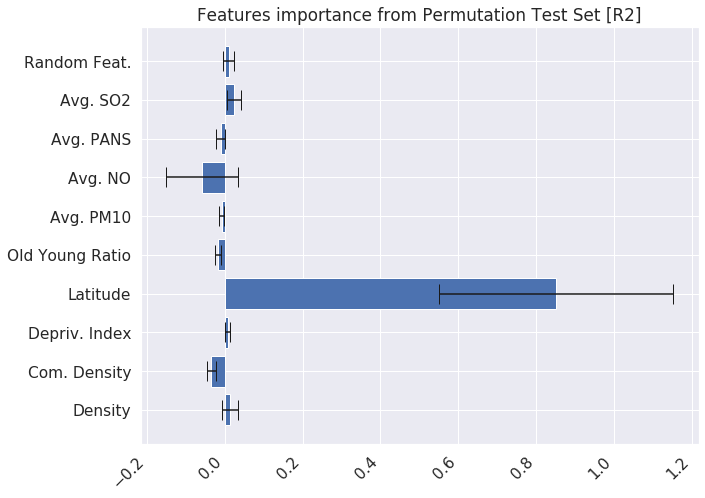

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.05014 +/- 0.01241
Feature:                   Com. Density, Score: 0.03963 +/- 0.00818
Feature:                       Latitude, Score: 1.75752 +/- 0.47513
Feature:                        Avg. NO, Score: 0.26083 +/- 0.06224
Feature:                       Avg. SO2, Score: 0.02910 +/- 0.00830


<Figure size 432x288 with 0 Axes>

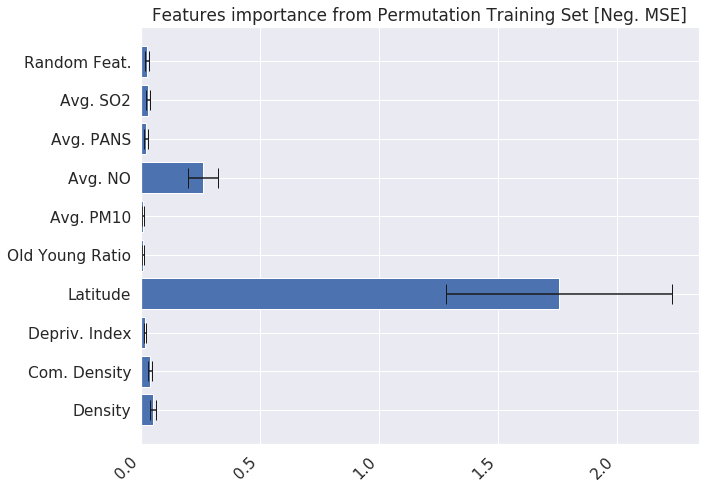

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.03301 +/- 0.00817
Feature:                   Com. Density, Score: 0.02609 +/- 0.00539
Feature:                       Latitude, Score: 1.15719 +/- 0.31283
Feature:                        Avg. NO, Score: 0.17173 +/- 0.04098
Feature:                       Avg. SO2, Score: 0.01916 +/- 0.00546


<Figure size 432x288 with 0 Axes>

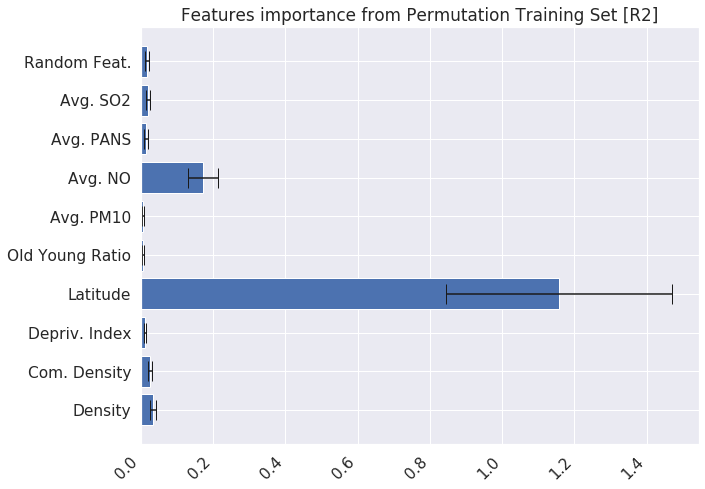

<Figure size 720x720 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_traininingset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...


In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Test Set 

In [ ]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_testset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)